## Lab 1: AI Travel Assistant Use Case Introduction



### Introduction

In this first Lab, we will introduce the AI Travel Assistant use case, discuss the data sources, core features of AI Agents with Bedrock and Open Source Agent Framework LangChain and set up the packages and dependencies that is required for the rest of the Labs.

The use case is to help create a bot which 
- Finds similiar destinations based on the user preferences using `RAG`
- Can book travel including hotel and flight
- Leverages `Tools` to exeute the actions
- Asks for `Human Confirmation` for critical exeution flows

The diagram will be similiar to this below

<img src="./images/travel_agent_light.png" width="65%" alt='travel_agent_light.png'/> 


### Use Case

Imagine having an AI assistant that can help you plan your next vacation, catering to all your preferences and needs. That's exactly what our "AI Travel Assistant" does—a cutting-edge, agentic AI system built using LangGraph and Amazon Bedrock Models. This assistant is designed to make travel planning seamless, offering personalized and data-driven suggestions every step of the way.

We will cover following scenarios in this workshop

1. **Lab 2: Introduction to the concepts of Agents including LangGrah and ReACT agents. We will introduce memory concepts in this lab:** 

Understand what it takes to build a agentic system.

2. **Lab 3: Dream Destination Planning with Introduvtion of RAG to the pipeline for Customized Travel Itineraries:** 

Get personalized recommendations for your next dream destination. Create vacation plans tailored specifically to your preferences and based on your past travels.

3. **Lab 4: Similar Travelers Based Recommendations:** 

Receive recommendations influenced by the preferences of travelers in a similar age group and geographic location.Book, modify, and cancel flight and hotel reservations—all through one assistant.

4. **Lab 5: Dream Destination with crew.ai for comparisions:** 

Book, modify, and cancel flight and hotel reservations—all through one assistant.

5. **Lab 6: Agentic Evaluation with RAGAS:** 

Understand how to evaluate the Agentic workflows using the open soyrce RAGAS library.

### Dataset

Introduction to the data set we wil be using for this workshop

#### 1. Travel History: 

We have synthetically created travel history dataset we will levearge in this workshop, it contains following fields

- Name: The individual's full name.
- Current_Location: The city where the individual currently resides.
- Age: The individual's age in years.
- Past_Travel_Destinations: Cities the individual has previously visited, listed as comma-separated values.
- Number_of_Trips: The total count of trips the individual has taken.
- Flight_Number: The flight number associated with each trip taken.
- Departure_City: The city from which each flight departed.
- Arrival_City: The destination city for each flight.
- Flight_Date: The date of each flight taken.

In [ ]:
import pandas as pd

df = pd.read_csv("./data/synthetic_travel_data.csv")
df.head(10)

#### 2. US and Europe City Dataset

For the purpose of the Retrieval Augmented generation(RAG) demonstrations in the labs, we have synthetically created PDF datasets to be ingested in the Vector DBs. Following is a sample PDF organises in `/data/us` and `/data/europe` folders respectively. We have used an Agentic implementation to create the dataset. You can check this out in the optional notebook provided

In [ ]:
from IPython.display import Image
Image(filename='./images/vegas.png') 

### Amazon Bedrock Model Access

[Amazon Bedrock](https://aws.amazon.com/bedrock/) offers a variety of foundation models (FMs) that are optimized for different use cases, making it a versatile platform for building generative AI applications. For agentic workflows, where models interact with tools, make decisions, and carry out complex tasks autonomously, choosing the right FM is crucial. For the purposes of this demostration, we will use the foundational models available on Amazon Bedrock with a focus on Anthropic Claude, Meta’s models, and Amazon’s own models, highlighting their capabilities for demonstration purposes. You can take a look [Supported foundation models in Amazon Bedrock](https://docs.aws.amazon.com/bedrock/latest/userguide/models-supported.html)

In [ ]:
import boto3

region = 'us-east-1'
bedrock = boto3.client(
    service_name = 'bedrock-runtime',
    region_name = region,
)

#### Anthropic's Claude in Amazon Bedrock

The `langchain_aws` package is a tool for integrating and interacting with Amazon Bedrock's language models through the LangChain framework. It provides following benefits

- Simplified Access to Amazon Bedrock Models
- Support for Conversational AI and Agentic Workflows

- `from langchain_aws.chat_models.bedrock:` This imports the ChatBedrock class from the langchain_aws package, specifically from the chat_models module.
- `ChatBedrock:` This is a class that allows interaction with Amazon Bedrock’s chat models, enabling users to create conversational AI applications using different foundational models available on Bedrock.

Refer [Anthropic's Claude in Amazon Bedrock](https://aws.amazon.com/bedrock/claude/) for more details

### Converse API

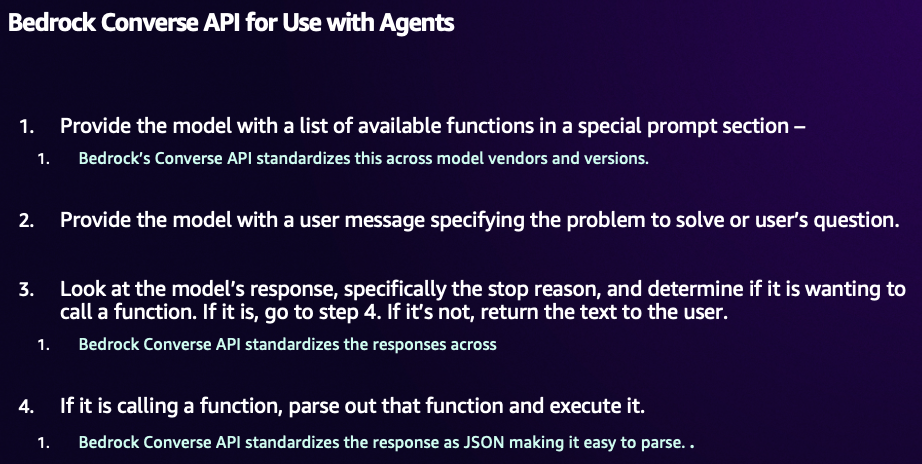

In [ ]:
!pip install langchain_aws

In [ ]:
from langchain_aws.chat_models.bedrock import ChatBedrock
from rich.console import Console
from rich.text import Text

# Create a console object
console = Console()

modelId = 'anthropic.claude-3-haiku-20240307-v1:0'
llm = ChatBedrock(
    model_id=modelId,
    client=bedrock,
    beta_use_converse_api=True
)


response = llm.invoke("I am planning a trip  with my family to Hawai next summer, can you give me a travel iternary for 5 days").content
# Format the text as a rich Text object
formatted_text = Text.from_markup(response)

# Print the formatted response using rich
console.print(formatted_text)

### Course-grained model comparison

In this section, we experiment with multiple models available on Amazon Bedrock and run course-grained evaluation on one of our task of interest. With the thousands of available models on the market, it is intractable to evaluation every single one. Hence, it is generally necessary to pre-filter for the ones that are not only from trusted providers, but have shown strong performance on a variety of benchmarks. 

Amazon Bedrock allows you to make a quick short-list by supporting a growing list providers such as Anthropic, Meta, Mistral, Cohere, AI21Labs, Stability AI and Amazon. This lets you start with a strong base to continue the model selection process.

Next we perform course-grained model evalution on the following models to inform our initial choice of model for our task of interest:
- Anthropic: Claude 3 Sonnet
- Anthropic: Claude 3 Haiku
- Meta:Llama 3.1 8B

To perform an initial evaluation, we create a small curated dataset of 10 examples. The optimal initial number of examples should be sufficiently big to roughly cover the types of queries our customers will send our model. Since this stage of the model evaluation process is meant to get a rough idea, the number of examples can be small.

To start, our scenario can be described by summarization (**task**) of vacation destinations (**what**) asked by travelers (**who**) at the time of development (**when**) in English (**language**). The set of initial questions can be found in [examples.txt](./data/examples.txt). We could expand our test by changing one or more of the variables composing the scenario of interesting. For instance, we could generate equivalent examples, but asked by people who aren't travelers or by others speaking in any other languages.

In [ ]:
with open("./data/examples.txt", "r") as file:
    examples = file.read().splitlines()

In [ ]:
import pandas as pd
from langchain_core.messages import HumanMessage, SystemMessage
from rich.console import Console
from rich.text import Text

pd.set_option('display.max_colwidth', None)
# Create a console object
console = Console()


def generate_answers(
    examples: list = [],
    system_prompt: SystemMessage = None
):
    modelIds = [
        "anthropic.claude-3-haiku-20240307-v1:0",
    ]
    output = pd.DataFrame({
        'example': [],
        'Claude3Haiku': [],
    })
    for example in examples:
        results = [example]
        for modelId in modelIds:
            messages = [
                system_prompt if system_prompt else SystemMessage(content=""),
                HumanMessage(content=example)
            ]
            llm = ChatBedrock(
                model_id=modelId,
                client=bedrock,
                beta_use_converse_api=True
            )
            resp = llm.invoke(messages).content
            results.append(resp)
        output.loc[len(output)] = results
    return output

In [ ]:
one_example = examples
output = generate_answers(one_example)
output.head()

### Conclusion

In this notebook, we established 
- the use case scope of the labs covered in this workshop
- datasets we will be using all the labs
- Amazon bedrock models used in this

Please proceed to the next labs